In [34]:
from __future__ import print_function
import numpy as np
import tensorflow as tf 
import mf
import matplotlib.pyplot as plt
import sudoku
from tqdm import tqdm

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [70]:
meanfield_iters = 50
n_epoch = 50
learning_rate = 0.01
n_modes = 2
n = 10
p = 3
n_samples = 1000
batch_size = 50

In [71]:
def grid_to_clip(grid):
    n_samples,n,_,p = grid.shape
    res = np.zeros((n_samples,2,n,n,p))
    res[:,0,:,:,:] = -50
    res[:,1,:,:,:] = np.where(grid == 1, -50, 50)
    return res

def to_prob(grid,p):
    m,_ = grid.shape
    prob_grid = np.zeros((m,m,p))
    for x in range(m):
        for y in range(m):
            if grid[x,y] != p:
                prob_grid[x,y,grid[x,y]] = 1
    return prob_grid

In [111]:
dataset_X, dataset_Y = [],[]


for _ in range(n_samples):
    x,y = np.random.randint(0,n),np.random.randint(0,n)
    sample = np.zeros((n,n),dtype=np.int32)
    
    if np.random.randint(0,2) == 0:
        sample = sample+2
        sample[(x+1)%n,(y+1)%n] = 0
        sample[x,y] = 1
    else:
        sample[(x+1)%n,(y+1)%n] = 2
        sample[x,y] = 1
        
    inpt = np.zeros((n,n),dtype=np.int32)+p
    inpt[x,y] = 1
    dataset_X.append(inpt)
    dataset_Y.append(sample)

dataset_X = [to_prob(x,p) for x in dataset_X]
dataset_Y = [to_prob(x,p) for x in dataset_Y]

inputs = grid_to_clip(np.array(dataset_X))
labels = np.array(dataset_Y)

In [112]:
print(sudoku.infer_grid(dataset_X[0]))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [114]:
tf_samples = tf.placeholder(tf.float32,[None, n, n, p])
links = tf.Variable(tf.zeros([n,n,p,p]))
links_sym = links+tf.transpose(links, [0, 1, 3, 2]) # pairwise weights are symmetric
unary = tf.Variable(tf.zeros([n,n,p]))
annealing = tf.Variable(tf.zeros([meanfield_iters]))

mmmf = mf.BatchedMultiModalMeanField(n, n, p, batch_size, links_sym, unary, tf.exp(annealing), meanfield_iters)

q_mf = tf.nn.softmax(-mmmf._theta_mf[-1]) #  sample, each mode, q values.
# tf_sample: (s, n, n, p)
# q_mf: (s*m, n, n, p)
q_mf = tf.reshape(q_mf, (batch_size,-1,n,n,p))

# q_mf: (s,m,n,n,p)

number_of_modes = tf.shape(q_mf)[1]
number_of_samples = tf.shape(tf_samples)[0]
tf_samples_stack = tf.tile(tf.expand_dims(tf_samples, 1), [1, number_of_modes, 1, 1, 1]) # of shape s, m, n, n, p
prod = tf_samples_stack*q_mf # broadcast magic -> s,m,n,n,p

# => log_lh: (s, m)
log_lh_samples = tf.reduce_sum(tf.log(tf.reduce_sum(prod,4)+0.0000001), (2,3))
#log likelihood for each sample each mode.
sample_mode = tf.argmax(log_lh_samples, axis=1)
# shape is [number_of_samples]
log_lh = tf.reduce_max(log_lh_samples, axis=1)

# sum of
energies = mmmf.get_modes_energy()
modes_prob = mmmf.get_modes_probability()
mean_energy = tf.reduce_sum(energies*tf.stop_gradient(modes_prob), axis=1)
energy_sample_mode = tf.gather(tf.transpose(energies), sample_mode)

to_maximize = tf.reduce_mean(log_lh - energy_sample_mode + mean_energy)
mean_log_lh = tf.reduce_mean(log_lh)
gradient_total = tf.gradients(to_maximize, [links, unary, annealing])
gradient_norm = tf.reduce_sum(tf.abs(gradient_total[0])) + tf.reduce_sum(tf.abs(gradient_total[1])) + tf.reduce_sum(tf.abs(gradient_total[2]))

update_rate = learning_rate*batch_size/float(n_samples)

update_weights = tf.assign(links, tf.check_numerics(links + update_rate*gradient_total[0],"weights_upd"))
update_unary = tf.assign(unary, tf.check_numerics(unary + update_rate*gradient_total[1],"unary_upt"))
update_annealing = tf.assign(annealing, tf.check_numerics(annealing + update_rate*gradient_total[2],"annealing_upd"))

print('tf graph is built')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

evol = [[],[],[]]
for i in tqdm(range(n_epoch),desc='epoch'):
    for b in range(n_samples/batch_size):
        #print(np.expand_dims(np.array(inputs[b*batch_size:(b+1)*batch_size]),axis=1).shape)
        mmmf.reset_all(np.expand_dims(np.array(inputs[b*batch_size:(b+1)*batch_size]),axis=1))
        for _ in range(n_modes): 
            mmmf.iteration(sess)

        parameters = {
                    mmmf._theta_clip: np.reshape(mmmf._modes,(-1,2,n,n,p)),
                    mmmf._T: 1,
                    tf_samples: labels[b*batch_size:(b+1)*batch_size]
                }
        loglh,loss,gradient,w,u,a = sess.run([mean_log_lh,to_maximize, gradient_norm, update_weights, update_unary, update_annealing], feed_dict=parameters)
        evol[0].append(loglh)
        evol[1].append(gradient)
        evol[2].append(loss)
        


(50, 10, 10, 3, 3)
(10, 10, 3, 3)
tf graph is built



epoch:   2%|▏         | 1/50 [00:07<06:27,  7.91s/it]

epoch: 100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


In [86]:
 parameters = {
                    mmmf._theta_clip: np.reshape(mmmf._modes,(-1,2,n,n,p)),
                    mmmf._T: 1./10.,
                    tf_samples: labels[b*batch_size:(b+1)*batch_size]
                }
sudoku.infer_grid(sess.run(q_mf[0,1], feed_dict=parameters))

array([[1, 2, 0, 0, 0, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 2, 2, 2, 2],
       [2, 2, 0, 0, 0, 0, 2, 2, 2, 2],
       [2, 2, 2, 0, 0, 0, 0, 2, 2, 2],
       [2, 2, 2, 2, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 2, 2, 0, 0, 0, 0],
       [0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
       [0, 0, 2, 2, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 2, 2, 2, 2, 2, 0]])

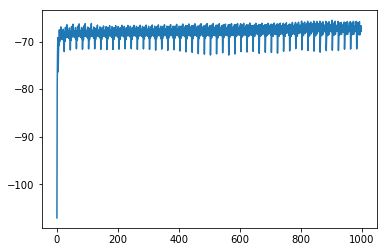

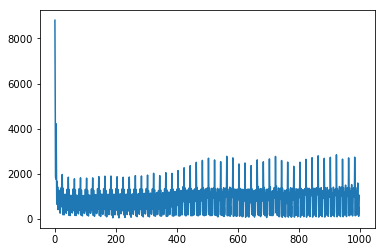

In [87]:
plt.plot(evol[0])
plt.figure()
plt.plot(evol[1])